In [1]:
%pip install yfinance
%pip install ta
%pip install --upgrade pandas-datareader
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Requirement already up-to-date: pandas-datareader in c:\users\weilin\anaconda3\lib\site-packages (0.10.0)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from datetime import date, timedelta
from tqdm import tqdm_notebook
from enum import Enum
from ta.trend import SMAIndicator
from ta.volatility import AverageTrueRange
from statsmodels.tsa.stattools import coint

import numpy as np
import pandas as pd
import math
import heapq as heap
import pandas_datareader as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sb

C:\Users\Weilin\Anaconda3\lib\site-packages\scipy\__init__.py:149: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.2
  UserWarning)


# Pair Trading Strategy

Pair trading strategy is when the ratio 2 highly correlated and cointegrated stocks, diverage from their mean due to some underlying conditions ie, market volumne, insider information and market changes. Since the 2 price series are cointegrated, we can safely assume that the prices will converge back to their mean. 

Rather than correlation, we will be picking our stocks based on **cointergration**. 

In our strategy, we will be primarily using 3 types of ratio to help generate signals for our positions
1. RAW_RATIO: Raw Price Ratio of 2 stock prices<br>
***Raw Ratio Z-score = (Price Ratio - Mean of Price Ratio) / Standard Deviation<br><br>***

2. MA_RATIO: Simple Moving Average Ratios based on 2 stock prices<br>
***MA Ratio Z-score = (MA<sub>Short Term</sub> - MA<sub>Long Term</sub>)  / Standard Deviation<sub>MA Long Term</sub>*** <br><br>

3. ATE_RATIO: ATR Spread Ratio based on 2 stock prices<br>
*ATR Spread = ATR<sub>Ticker_1</sub> / ATR<sub>Ticker_2</sub><br>*
*ATR Ratio = (Price<sub>Ticker_1</sub> / Price<sub>Ticker_2</sub> ) * ATR Spread<br>*
***ATR Ratio Z-Score = (ATR Ratio - Mean<sub>ATR Ratio</sub>)  / Standard Deviation<sub>ATR Ratio</sub><br><br>***


These 3 variations of the strategy will be defined by the Strategy_Type Emun Class as shown below

By normalising the price ratio generated by the desired strategy variation, we will be able to generate signals based on the normalised spread.

In the Pair Strategy Class, we will be setting the signal thresholds for each variation and once the price ratio is within **±0.05**, a long or short position will be open.

For example, if the given threshold is 1:
1. Given price ratio is **-1.04** (within -0.05 of threshold), a long signal is generated on the price ratio graph and we will **Long** ticker_1 and **Short** ticker_2<br>
2. Given price ratio is **1.04**(within +0.05 of threshold), a short signal is generated on the price ratio graph and we will **Short** ticker_1 and **Long** ticker_2\

All positions of the pair will be closed if the price ratio is within **±0.05**

## Cointegration

Cointegration, not the be confused with correlation, means the ratio of 2 series converge around the mean. In order for pair trading to be ideal, both of the price series must be cointegrated. 

If a both series are cointegrated, we could use mean reversion strategy of both stocks to ideally generate returns for our strategy. 

In order to find a cointegrated pair, we must find the pvalues of all permutations of the given list of tickers. If the **pvalue < 0.05**, we can say that the pair is cointegrated. 

In [3]:
# Enum class for different iterations of indicators
class Strategy_Type(Enum):
    RAW_RATIO = "RAW_RATIO"
    MA_RATIO = "MA_RATIO"
    ATR_RATIO = "ATR_RATIO"

## Variables of the Strategy

1. ***stocks*** are the list of stock tickers that the user wish to run the strategy with. <br>
    Do note that not all tickers will be selected 
2. ***strategy_types*** are the types of strategy variation the user wish to run
3. ***number_of_pairs*** are the number of selected pairs the user wish to have
 
    


In [205]:
# DJ Information technology stocks
stocks = ["AAPL", "MSFT", "V", "CRM", "IBM", "CSCO", "INTC"]

# strategy_types = [Strategy_Type.RAW_RATIO, Strategy_Type.MA_RATIO, Strategy_Type.ATR_RATIO]
strategy_types = [Strategy_Type.ATR_RATIO]

number_of_pairs = 3

# Trade Class

Trade class encapsulate the logic of handling a single trade in our backtester.
For every Buy - Sell it will be counted as 1 trade. 

A Backtester will have many trades.


In [189]:
class Trade() :
    
    def __init__(self, symbol, date, open_price, position, quantity, transaction_cost) :
        
        self.symbol = symbol
        self.date = date
        self.open_price = open_price
        self.position = position
        self.quantity = quantity
        self.transaction_cost = transaction_cost
        
        self.total_transaction_cost = self.open_price * self.quantity * transaction_cost
        self.close_price = None
        self.close_date = None
        self.returns = None
        self.raw_profits = None      
        
    # closing of a trade
    # close a trade by adding its close date, close price and calculating the returns and profits of the trade
    def close_trade(self, close_date, close_price) :
        
        self.close_price = close_price
        self.close_date = close_date
        self.total_transaction_cost += self.quantity * close_price * self.transaction_cost
        opening_cost = self.open_price * self.quantity* (1 + self.transaction_cost)
        closing_cost = close_price * self.quantity* (1 - self.transaction_cost)
        
        if self.position == 1 :
            self.returns = np.log(closing_cost / opening_cost)
            self.raw_profits = ((self.close_price - self.open_price) * self.quantity) - self.total_transaction_cost
            
        elif self.position == -1 :
            self.returns = np.log(opening_cost / closing_cost)
            self.raw_profits = ((self.open_price - self.close_price) * self.quantity) - self.total_transaction_cost        
        
    
    # get the current unrealised profits at a given price
    def get_unrealised_profits(self, current_price) :
        
        # if it is a short position, we need to get the difference in opening price and current price
        # if its open price > current price , positive profits
        # else negative profits
        if self.position == -1 :
            price_delta = self.open_price - current_price 
            return (self.open_price + price_delta) * self.quantity
        # if long position -> urealised profits == equity price
        else :
            return current_price  * self.quantity
    
    
    # print string representation of a completed trade
    def print_trade(self) :
        action = "Buy" if self.position == 1 else "Sell"
        print("=============================================================")
        print(f"Open Trade {self.symbol} | {self.date[:10]} | {action}")
        print("===============")
        print(f"Open Price: ${round(self.open_price, 2)}")
        print(f"Quantity: {self.quantity}")
        print(f"Transaction Cost: ${round(self.transaction_cost * self.open_price * self.quantity, 2)}")
        print(f"Total Price: ${round(self.open_price * self.quantity* (1 + self.transaction_cost), 2)}")
        print()
        action = "Sell" if self.position == 1 else "Buy"
        print(f"Closing Trade {self.symbol} | {self.close_date[:10]} | {action}")
        print("===============")
        print(f"Close Price: ${round(self.close_price, 2)}" )
        print(f"Quantity: {self.quantity} ")
        print(f"Transaction Cost: ${round(self.transaction_cost * self.close_price * self.quantity, 2)}")
        print(f"Total Transaction Cost: ${round(self.total_transaction_cost, 2)}")
        print(f"Total Price: ${round(self.close_price * self.quantity* (1 + self.transaction_cost), 2)}")
        print(f"Log Returns: {round(self.returns, 2)}")
        print(f"Raw Profits: ${round(self.raw_profits, 2)}")
        print("=============================================================")
        



# BackTester

Since we will be handling multiple stocks, trade logic will be encapsulate in the Trade Class and Backtester class will be mainly handling the logic of Buying and Selling.

We will also need to store the different trades in a dictionary to keep track of all the different stocks. 

# Assumptions Made
1. At a single instance, each individual stock can only have one open trade.

2. Opening and Closing a Trade is counted as 1 Trade together

3. Capital Allocation to each stock is *Total Capital / n stocks* hence all stocks will have equal weights in the strategy.

4. Quantity is calculated base on the price and the transaction cost. <br>
For example, Capital of \\$1000 could buy 9 x \\$10 worth of stocks as the transaction cost is *tc x 9 x 10*. <br>
Hence the price needed is (9 x $10) + (tx x 9 x 10)

5. The formula used to derive the maximum quantity is : *Capital / (price + (price * TC))*

In [201]:
class BackTester():  

    def __init__(self, symbols, start, end, interval, capital, transcation_cost, market_benchmark, verbose = True):

        self.symbols = symbols
        self.start = start
        self.end = end
        self.interval = interval
        self.initial_capital = capital # this is the initial capital you want to trade with
        self.capital = capital # this capital will change depending on trades
        self.stocks_capital = {} ## fix allocation of cash for each symbol
        self.transaction_cost = transcation_cost # the transaction cost for trading
        self.history_trades = {} #upon closing a trade, the trade will be added here
        self.open_trades = {} # each stock will only have 1 trade open at a time 
        self.verbose = verbose # if you want to see detailed output (logs) 
        self.rolling_capital = pd.DataFrame() # captial daily status
        
        self.market_benchmark = market_benchmark # market benchmark symbol
        
        self.prepare_data() # prepares the data

    def prepare_data(self):
        bt_data = pd.DataFrame()
        for symbol in self.symbols : 
            stock_data = yf.Ticker(symbol)
            hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
            bt_data[f"Close_Price_{symbol}"] = hist_stock["Close"]
            bt_data[f"High_{symbol}"] = hist_stock["High"]
            bt_data[f"Low_{symbol}"] = hist_stock["Low"]
            bt_data[f"Return_{symbol}"] = np.log(bt_data[f"Close_Price_{symbol}"] / bt_data[f"Close_Price_{symbol}"].shift(1))

        benchmark_stock = yf.Ticker(self.market_benchmark)
        benchmark_hist = benchmark_stock.history(start = self.start, end = self.end, interval = self.interval)
        bt_data[f"Close_Price_{self.market_benchmark}"] = hist_stock["Close"]
        bt_data[f"Return_{self.market_benchmark}"] = np.log(bt_data[f"Close_Price_{self.market_benchmark}"] / bt_data[f"Close_Price_{self.market_benchmark}"].shift(1))
            
        bt_data = bt_data.dropna()
        self.data = bt_data
        
        self.rolling_capital["Date"] = self.data.index
        self.rolling_capital["Capital"] = self.capital
        self.rolling_capital.set_index('Date', inplace=True)
    
    # prepares cash allocation of each ticker
    # for example if only 3 pairs of stock is selected (6 tickers)
    # stocks_capital : {META : initial_capital / 6, AAPL :initial_capital / 6....}
    def prepare_cash_allocation(self, tickers) :
        self.stocks_capital = {}
        num_stocks = len(tickers)
        for ticker in tickers :
            self.stocks_capital[ticker] = self.initial_capital / num_stocks
    
    ## resets backtester to initial state
    # this is used to reset the backtester when we finish running one variation of the strategy
    def reset(self) :
        self.capital = self.initial_capital
        self.history_trades = {}
        self.open_trades = {}
        self.rolling_capital = pd.DataFrame()
        
        self.rolling_capital["Date"] = self.data.index
        self.rolling_capital["Capital"] = self.capital
        self.rolling_capital.set_index('Date', inplace=True)
        
        print("============================")
        print("Resetting BackTester")
        print("============================")
        print()

    def close_graph(self):
        for symbol in self.symbols : 
            plt.figure(figsize=(15, 5))
            plt.plot(self.data[f"Close_Price_{symbol}"] ,color='black', label='Price', linestyle='dashed')
            plt.xlabel("Days")
            plt.ylabel("Price")
            plt.title("Close Prices of {}".format(symbol))
            plt.legend()
            plt.grid()
            plt.show()     
            
    def return_date_price(self, bar, symbol=None):
        # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
        # Since we have modeled close prices, we will get the price and date
        date = str(self.data.index[bar])
        price = None
        if symbol :
            price = self.data[f"Close_Price_{symbol}"].iloc[bar]
        return date, price

    def realised_balance(self, bar):
        #Returns you the realised capital in your account at a given time period / bar
        date, price = self.return_date_price(bar)
        
        return self.capital

    def unrealised_balance(self, bar):
        #Returns you the unrealised capital (trades in progress) in your account at a given time period / bar
        ub = 0
        for symbol, trade in self.open_trades.items() :
            date, price = self.return_date_price(bar, symbol)
            ub += trade.get_unrealised_profits(price)
        
        return ub

    def total_balance(self, bar):
        #Unrealised plus realised
        ub = self.unrealised_balance(bar)
        tb = ub + self.capital
        
        return tb

    def get_returns(self) :
        return round(((self.capital - self.initial_capital) / self.initial_capital)  * 100, 2)
    
    def get_annual_gross_returns(self) :
        daily_log_mean_returns = self.rolling_capital["Capital_Log_Returns"].mean()
        annual_log_returns = 252 * daily_log_mean_returns
        annual_reg_returns = (np.exp(annual_log_returns) - 1) * 100
        
        return round(annual_reg_returns, 2)
    
    def get_market_returns(self) :
        market_log_returns = self.data[f"Return_{self.market_benchmark}"].sum()
        market_returns = (np.exp(market_log_returns) - 1) * 100      
        
        return round(market_returns, 2)
     
    def get_market_annual_gross_returns(self) :
        market_daily_log_mean_returns = self.data[f"Return_{self.market_benchmark}"].mean()
        market_annual_log_returns = 252 * market_daily_log_mean_returns
        market_annual_reg_returns = (np.exp(market_annual_log_returns) - 1) * 100
        
        return round(market_annual_reg_returns, 2)

    def buy_order(self, bar, symbol, quantity=None, dollar=None,):
        date, price = self.return_date_price(bar, symbol)
        quant = 0
        
        # if symbol is in open trades, there is a open short position
        if symbol in self.open_trades :
            current_trade = self.open_trades[symbol]
            current_trade.close_trade(close_date=date, close_price=price)
            
            if symbol in self.history_trades : 
                self.history_trades[symbol].append(current_trade)
            else : 
                self.history_trades[symbol] = [current_trade]
            
            quant = current_trade.quantity
            price_delta = current_trade.open_price - price
            
            difference = price_delta * quant 
            
            open_sum = current_trade.open_price * current_trade.quantity
            
            self.capital = self.capital - (quant * price)*(self.transaction_cost) + open_sum + difference
            self.stocks_capital[symbol] = open_sum + difference - (quant * price)*(self.transaction_cost)
            
            del self.open_trades[symbol]
        else :
            if quantity == None:
                quant = math.floor(self.stocks_capital[symbol] / (price + (self.transaction_cost * price)))
                
            new_trade = Trade(symbol=symbol, date=date, open_price=price, position=1, quantity=quant, transaction_cost=self.transaction_cost)
            self.open_trades[symbol] = new_trade 
            
            self.capital = self.capital - ((quant * price)*(1 + self.transaction_cost)) # capital will be lost in buying
            self.stocks_capital[symbol] = self.stocks_capital[symbol] - (quant * price)*(1 + self.transaction_cost)
                       
            
    def sell_order(self, bar, symbol, quantity=None, dollar=None):
        date, price = self.return_date_price(bar, symbol)
        quant = 0
        
        # if symbol is in open trades, there is a open long position
        if symbol in self.open_trades :
            current_trade = self.open_trades[symbol]
            current_trade.close_trade(close_date=date, close_price=price)
            if symbol in self.history_trades : 
                self.history_trades[symbol].append(current_trade)
            else : 
                self.history_trades[symbol] = [current_trade]
            
            quant = current_trade.quantity
            self.capital = self.capital + ((quant * price)*(1 - self.transaction_cost)) # capital will be added after selling
            self.stocks_capital[symbol] = (quant * price)*(1 - self.transaction_cost)
            
            del self.open_trades[symbol]
            
        else :
            if quantity == None:
                quant = math.floor(self.stocks_capital[symbol] / (price + (self.transaction_cost * price)))
            new_trade = Trade(symbol=symbol, date=date, open_price=price, position=-1, quantity=quant, transaction_cost=self.transaction_cost)
            self.open_trades[symbol] = new_trade
            
            self.capital = self.capital - ((quant * price)*(1 + self.transaction_cost))
            self.stocks_capital[symbol] = self.stocks_capital[symbol]- (quant * price)*(1 + self.transaction_cost)

    # Close any open position at the end of the backtesting
    def last_trade(self, bar):
        for symbol, trade in  self.open_trades.items() : 
            
            date, price = self.return_date_price(bar, symbol)
            
            trade.close_trade(close_date=date, close_price=price)
            
            if trade.position == 1 :
                if symbol in self.history_trades : 
                    self.history_trades[symbol].append(trade)
                else : 
                    self.history_trades[symbol] = [trade]
                quant = trade.quantity
                self.capital = self.capital + ((quant * price)*(1 - self.transaction_cost)) # capital will be added after selling
                self.stocks_capital[symbol] = (quant * price)*(1 - self.transaction_cost)
                
            else :
                if symbol in self.history_trades : 
                    self.history_trades[symbol].append(trade)
                else : 
                    self.history_trades[symbol] = [trade]
                quant = trade.quantity
                price_delta = trade.open_price - price

                difference = price_delta * quant 

                open_sum = trade.open_price * trade.quantity

                self.capital = self.capital - (quant * price)*(self.transaction_cost) + open_sum + difference
                self.stocks_capital[symbol] = open_sum + difference - (quant * price)*(self.transaction_cost)
        
        self.rolling_capital["Capital"].iloc[bar] = self.capital

        
    def calcuate_total_trades(self) :
        total_trades = 0
        for symbol, trades in self.history_trades.items() :
            total_trades += len(trades)

        return total_trades
    
    def log_all_trades(self) :
        for ticker, trades in self.history_trades.items() :
            for trade in trades : 
                trade.print_trade()
                
    def get_annual_reg_std(self) :
        daily_regular_std = (np.exp(self.rolling_capital["Capital_Log_Returns"]) - 1).std()
        annual_regular_std = daily_regular_std * (252**0.5) * 100
        
        return round(annual_regular_std, 2)
    
    def get_market_annual_reg_std(self) :
        daily_regular_std = (np.exp(self.data[f"Return_{self.market_benchmark}"]) - 1).std()
        annual_regular_std = daily_regular_std * (252**0.5) * 100
        
        return round(annual_regular_std, 2)
                                
    def get_beta(self) :
        cov = self.data[f"Return_{self.market_benchmark}"].cov(self.rolling_capital["Capital_Log_Returns"])
        market_var = self.data[f"Return_{self.market_benchmark}"].var()
                
        beta = cov/market_var
        
        return round(beta, 2)
    
    def get_alpha(self) :
        strategy_returns = self.get_annual_gross_returns()
        market_returns = self.get_market_annual_gross_returns()
        beta = self.get_beta()
        alpha = (strategy_returns - (beta * (market_returns)))
        
        return round(alpha, 2)
    
    
    def get_sharpe_ratio(self) :
        annual_regular_returns = self.get_annual_gross_returns()
        annual_regular_std = self.get_annual_reg_std()
        
        sharpe_ratio = annual_regular_returns / annual_regular_std
        
        return round(sharpe_ratio, 2)
    
    def plot_strategy_returns_market_returns(self) :
        plt.figure(figsize=[15,5])
        plt.plot(self.rolling_capital["Capital_Log_Returns"].cumsum(), label="Strategy Returns")
        plt.plot(self.data[f"Return_{self.market_benchmark}"].cumsum(), label=f"{self.market_benchmark} Returns")
        plt.title("Strategy Log Returns VS DJI Log Returns")
        
        plt.legend()
        plt.show()
        plt.close()       
        
        
    def performance(self) :
        self.rolling_capital["Capital_After_Resettlement"] = self.rolling_capital["Capital"].shift(-1)

        self.rolling_capital['Capital_Regular_Returns'] = (self.rolling_capital['Capital_After_Resettlement']/self.rolling_capital['Capital'] - 1)
        self.rolling_capital['Capital_Log_Returns'] = np.log(self.rolling_capital['Capital_After_Resettlement'] / self.rolling_capital['Capital'])
        self.rolling_capital['Capital_Returns_Log_Cum_Sum'] = self.rolling_capital['Capital_Log_Returns'].cumsum()

        self.rolling_capital['Cum_Max'] = self.rolling_capital['Capital_Returns_Log_Cum_Sum'].cummax()

        self.rolling_capital[["Capital_Returns_Log_Cum_Sum", f"Cum_Max"]].dropna().plot(figsize =(15,6), title="Capital DrawDown")
        
        strategy_returns = self.get_returns()
        annual_gross_returns = self.get_annual_gross_returns()
        strategy_std = self.get_annual_reg_std()
        alpha = self.get_alpha()
        beta = self.get_beta()
        sharpe_ratio = self.get_sharpe_ratio()
        
        market_returns = self.get_market_returns()
        market_annual_returns = self.get_market_annual_gross_returns()
        market_std = self.get_market_annual_reg_std()

        neg_trades = 0
        pos_trades = 0
        total_trades = 0
        sum_log_returns = 0
        trade_returns  = []
        for symbol, trades in self.history_trades.items():
            for trade in trades:
                total_trades += 1
                sum_log_returns += trade.returns
                trade_returns.append(trade.returns)
                if trade.raw_profits > 0:
                    pos_trades += 1
                if trade.raw_profits < 0:
                    neg_trades += 1
        
        print("================================")
        print(f"Total number of trades made: {total_trades}")
        print(f"Total number of winning trades: {pos_trades}")
        print(f"Total number of losing trades: {neg_trades}")
        print(f"Win Rate: {round((pos_trades/total_trades) * 100, 2)}%")
        print(f"Mean log returns: {round((sum_log_returns/total_trades) * 100, 2)}%")
        print("================================")
        
        plt.figure(figsize=(10, 5))
        plt.hist(trade_returns, bins=40)
        plt.title("Overall Trade Returns")
        plt.grid()
        plt.show()
        plt.close()
        
        
        print()
        print("Strategy Performance")
        print("==================================")
        print(f"Strategy Returns: {strategy_returns}%")
        print(f"Strategy Annual Gross Returns: {annual_gross_returns}%")
        print(f"Strategy Standard Deviation: {strategy_std}")
        print(f"Alpha: {alpha}")
        print(f"Beta: {beta}")
        print(f"Sharpe Ratio: {sharpe_ratio}")
        print()
        print("Market Performance")
        print("==================================")
        print(f"Market Returns: {market_returns}%")
        print(f"Market Annual Gross Returns: {market_annual_returns}%")
        print(f"Market Standard Deviation: {market_std}")
        print()
        
        self.get_extended_metrics()
        self.plot_strategy_returns_market_returns()

    def calmar_ratio(self) :
        max_drawdown = max(self.rolling_capital['Cum_Max'] - self.rolling_capital['Capital_Returns_Log_Cum_Sum'])
        return self.get_returns()/(max_drawdown*100)

    def sortino_ratio(self) :
        negative_returns_df = self.rolling_capital[self.rolling_capital["Capital_Log_Returns"] < 0]
        negative_returns = negative_returns_df["Capital_Log_Returns"]

        negative_regular_returns = np.exp(negative_returns) - 1

        annual_negative_sd = negative_regular_returns.std() * (252 ** 0.5)

        sortino = (self.get_returns() / 100) / annual_negative_sd

        return round(sortino, 2)

    def information_ratio(self) :   

        temp_data = self.rolling_capital.copy()

        temp_data["Market_Returns"] = self.data[f"Return_{self.market_benchmark}"]

        temp_data["Strategy_Benchmark"] = temp_data["Capital_Log_Returns"] - temp_data["Market_Returns"]

        average_of_difference = temp_data["Strategy_Benchmark"].mean()

        std_dev_of_difference = temp_data["Strategy_Benchmark"].std()

        IR_daily = average_of_difference / std_dev_of_difference
        IR_annual = IR_daily * (252 ** 0.5)

        return round(IR_annual, 2)

    def treynor_ratio(self) :
        
        strategy_returns = self.get_returns() / 100
        beta = self.get_beta()
        treynor_ratio = strategy_returns / beta
        
        return round(treynor_ratio, 2)

    def get_extended_metrics(self) :
        print(f"Calmar Ratio: {self.calmar_ratio()}")
        print(f"Sortino Ratio: {self.sortino_ratio()}")
        print(f"Annual Information Ratio: {self.information_ratio()}")
        print(f"Treynor Ratio: {self.treynor_ratio()}")
 

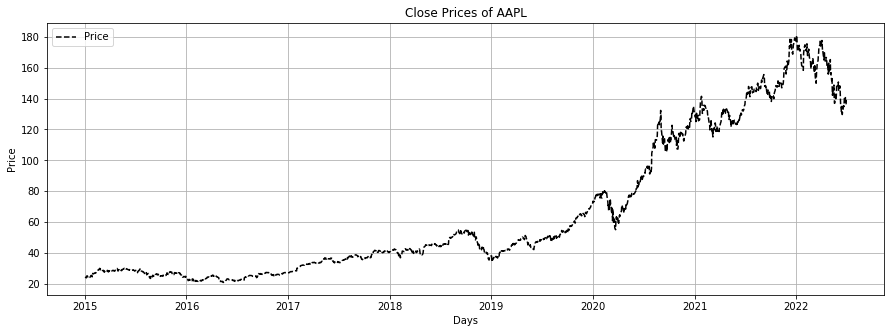

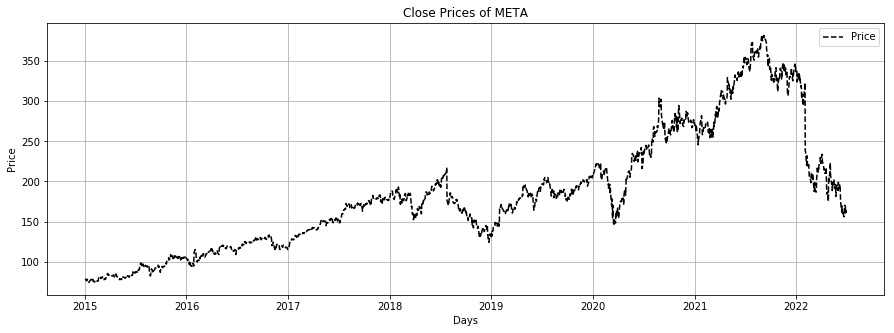

In [202]:
#check if common class runs fine
A = BackTester(["AAPL", "META"], "2015-01-01", "2022-07-01","1d", 10000, 0.0, "^GSPC", False)
A.close_graph()

In [203]:
class Pair_Strategy(BackTester):
    
    def __init__(self, symbols, start, end, interval, capital, 
                 transcation_cost, market_benchmark, verbose = True, 
                 cointegration_threshold = 0.05, number_pairs = 3, 
                 types = [Strategy_Type.RAW_RATIO, Strategy_Type.MA_RATIO, Strategy_Type.ATR_RATIO]) :
        
        super().__init__(symbols, start, end, interval, capital, transcation_cost, market_benchmark, verbose)
        
        self.types = types
        
        self.cointegration_matrix =  np.zeros((len(symbols), len(symbols))) # cointegration p value for all permutations 
        self.selected_pairs = [] # list of selected pairs the strategy will run
        self.cointegration_heap = [] # min heap for sorting and selecting of pairs
        self.cointegration_threshold = cointegration_threshold
        self.number_pairs = number_pairs
        
        self.price_signals = pd.DataFrame()
        
        # thresholds for different indicators for generating signals
        self.strategy_threshold = {Strategy_Type.RAW_RATIO : 1, 
                                  Strategy_Type.MA_RATIO : 0.75,
                                  Strategy_Type.ATR_RATIO : 0.75}
        
    
    def __get_cointegration_p_value__(self, ticker_1, ticker_2) :
        
        results = coint(self.data[f"Close_Price_{ticker_1}"], self.data[f"Close_Price_{ticker_2}"])
        return results[1]
    
        
    def __compute_pairs__(self) :
        
        for i in range(len(self.symbols)) :
            for j in range(i + 1, len(self.symbols)) :
                coint_p_value = self.__get_cointegration_p_value__(self.symbols[i], self.symbols[j])
                self.cointegration_matrix[i, j] = coint_p_value
                
                # we wil be using min heap to keep track of the lowest p-value
                heap.heappush(self.cointegration_heap, (coint_p_value, f"{self.symbols[i]}/{self.symbols[j]}"))
                
        if self.verbose :  
            ## Cointegration Matrix
            plt.figure(figsize = (16,6))
            sb.heatmap(self.cointegration_matrix, xticklabels=self.symbols, yticklabels=self.symbols, annot=True, mask=(self.cointegration_matrix == 0))
            plt.title("Conintegrations p-value Matrix")
            plt.show()
                               
    def __select_pairs__(self) :
    
        selected_map = {}

        min_cointegration = self.cointegration_heap[0][0]
        
        if (min_cointegration >= self.cointegration_threshold) :
            print("No Suitables Pairs Found based on Cointegration Test")
            print(f"Selecting the next best {self.number_pairs} unique pairs")
            print()
            
        while len(self.selected_pairs) < self.number_pairs :
            try : 
                pair_tuple = heap.heappop(self.cointegration_heap)
                p_value = pair_tuple[0]
                pair = pair_tuple[1]
                
                ticker_1, ticker_2 = self.__get_tickers_from_pair__(pair)

                if ticker_1 not in selected_map and ticker_2 not in selected_map :
                    self.selected_pairs.append(pair)
                    
                    if p_value > self.cointegration_threshold :
                        print(f"Warning pair: {pair} not best suitable for this strategy.")
                        print("Returns might be negative")
                        print()

                    selected_map[ticker_1] = 1
                    selected_map[ticker_2] = 1 
            except IndexError :
                print(f"Unable to find {self.number_pairs} Unique Pairs")
                print(f"Only {len(self.selected_pairs)} Unique Pairs Found")
                print()
                break;
                
        if self.verbose :
            print(f"Selected Pairs: {self.selected_pairs}")
    
    ## compute price ratio of a single pair
    def compute_price_ratio(self, pair) :
        
        ticker_1, ticker_2 = self.__get_tickers_from_pair__(pair)
        
        price_ratio = self.data[f"Close_Price_{ticker_1}"]/ self.data[f"Close_Price_{ticker_2}"]
        
        if self.verbose :
            price_ratio.plot(figsize=(16,5))
            plt.title(f"{pair} Price Ratio")
            plt.axhline(price_ratio.mean())
            plt.legend(['Mean'])
            plt.show()
            plt.close()
        
        return price_ratio
    
    
    # compute 2(Long term and short term) moving MAs of the spread of a given pair
    def compute_rolling_price_ratio(self, price_ratio, STMA_window = 10, LTMA_window = 50) :
        
        indicator_1 = SMAIndicator(close=price_ratio, window=STMA_window, fillna=False)
        STMA = indicator_1.sma_indicator()
            
        indicator_2 = SMAIndicator(close=price_ratio, window=LTMA_window, fillna=False)
        LTMA= indicator_2.sma_indicator()
        
        if self.verbose :
            vis_df = pd.DataFrame()
            vis_df["Price_Ratio"] = price_ratio
            vis_df["STMA"] = STMA
            vis_df["LTMA"] = LTMA
            
            plt.figure(figsize=[15,5])
            plt.title(f"MA Price Ratio, {price_ratio.name}")
            plt.plot(vis_df["Price_Ratio"], label="Price Ratio")
            plt.plot(vis_df["STMA"], label="STMA")
            plt.plot(vis_df["LTMA"], label="LTMA")
            
            plt.legend()
            plt.show()
            plt.close()         
        
        return STMA, LTMA
    
    
    #compute ATR price ratios of a given pair
    def compute_atr_price_ratios(self, pair, window= 14) :
        pair_tuple = pair.split("/")
        ticker_1 = pair_tuple[0]
        ticker_2 = pair_tuple[1]
        
        ATR_ratio = self.data[f"ATR_{ticker_1}"] / self.data[f"ATR_{ticker_2}"]
        
        ATR_spread = (self.data[f"Close_Price_{ticker_1}"] / self.data[f"Close_Price_{ticker_2}"]) * ATR_ratio
        
        ATR_spread.name = f"ATR {pair}"
        
        if self.verbose :
            plt.figure(figsize=[15,5])
            plt.title(f"ATR Price Ratio, {pair}")
            plt.plot(ATR_spread, label="ATR Price Ratio")
            
            plt.legend()
            plt.show()
            plt.close()         
        
        return ATR_spread
        
    
    # compute the z score given a price ratio
    def compute_z_scores(self, price_ratio, strategy_type, STMA = None, LTMA= None) :
        z_score = None
        if LTMA is not None and STMA is not None:
            name = f"MA {price_ratio.name}"
            price_ratio = STMA
            price_ratio.name=name
            z_score = (STMA - LTMA) / LTMA.std()
            
        else :
            mean = price_ratio.mean()
            z_score = (price_ratio - mean) / np.std(price_ratio)
        
        if self.verbose :
            z_score.plot(figsize=(15,5))
            plt.title(f"Z-score Plot, {price_ratio.name}")
            plt.axhline(z_score.mean(), color='black')
            plt.axhline(self.strategy_threshold[strategy_type], color='red', linestyle='--')
            plt.axhline(-self.strategy_threshold[strategy_type], color='green', linestyle='--')
            plt.legend(['Z-score', 'Mean'])
            plt.show()
        
        
        return z_score
    
    def __generate_trading_tickers_from_pairs__(self) :
        trading_tickers = []
        
        for pair in self.selected_pairs :
            ticker_1, ticker_2 = self.__get_tickers_from_pair__(pair)
            trading_tickers.append(ticker_1)
            trading_tickers.append(ticker_2)
            
        return trading_tickers
    
    def __get_tickers_from_pair__(self, pair) :
        
        pair_split = pair.split("/")
        
        return pair_split[0], pair_split[1]
    
    def __compute_atr__(self, pair, window=14) :
        
        ticker_1, ticker_2 = self.__get_tickers_from_pair__(pair)
        
        
        ATR_1 = AverageTrueRange(high=self.data[f"High_{ticker_1}"], low=self.data[f"Low_{ticker_1}"], close=self.data[f"Close_Price_{ticker_1}"], window=window)
        ATR_2 = AverageTrueRange(high=self.data[f"High_{ticker_2}"], low=self.data[f"Low_{ticker_2}"], close=self.data[f"Close_Price_{ticker_2}"], window=window)
        
        ATR_1_values = ATR_1.average_true_range()
        ATR_2_values = ATR_2.average_true_range()
        
        self.data[f"ATR_{ticker_1}"] = ATR_1_values
        self.data[f"ATR_{ticker_2}"] = ATR_2_values
        
    
    def __prepare_signals__(self) :
        self.__compute_pairs__()
        self.__select_pairs__()
        
        for pair in self.selected_pairs :
            
            self.__compute_atr__(pair, window=14)   
            price_ratio = self.compute_price_ratio(pair)
            price_ratio.name = pair
            
            rolling_price_ratio_STMA, rolling_price_ratio_LTMA = self.compute_rolling_price_ratio(price_ratio, STMA_window=5, LTMA_window = 60)
            
            atr_ratio = self.compute_atr_price_ratios(pair, window=14)
            
            price_ratio_zscore = self.compute_z_scores(price_ratio, strategy_type=Strategy_Type.RAW_RATIO)
            
            rolling_price_ratio_zscore = self.compute_z_scores(price_ratio, strategy_type=Strategy_Type.MA_RATIO, STMA=rolling_price_ratio_STMA, LTMA=rolling_price_ratio_LTMA)
            
            atr_zscore = self.compute_z_scores(atr_ratio, strategy_type=Strategy_Type.ATR_RATIO)
            
            self.price_signals[f"{pair}_RAW_RATIO_Zscore"] = price_ratio_zscore
            self.price_signals[f"{pair}_MA_RATIO_Zscore"] = rolling_price_ratio_zscore
            self.price_signals[f"{pair}_ATR_RATIO_Zscore"] = atr_zscore
            
    def __plot_positions__(self) :

        for pair in self.selected_pairs :
        
            ticker_1, ticker_2 = self.__get_tickers_from_pair__(pair)
            
            plt.figure(figsize=[15,5])
            plt.plot(self.data[f"Close_Price_{ticker_1}"], label=ticker_1)
            plt.plot(self.data[f"Close_Price_{ticker_2}"], label=ticker_2)

            long_dates = []
            long_prices = []
            short_dates = []
            short_prices = []
            close_dates = []
            close_prices = []

            for trade in self.history_trades[ticker_1] :

                close_dates.append(trade.close_date)
                close_prices.append(trade.close_price)

                if trade.position == 1 :
                    long_dates.append(trade.date)
                    long_prices.append(trade.open_price)

                else :
                    short_dates.append(trade.date)
                    short_prices.append(trade.open_price)

            for trade in self.history_trades[ticker_2] :

                close_dates.append(trade.close_date)
                close_prices.append(trade.close_price)

                if trade.position == 1 :
                    long_dates.append(trade.date)
                    long_prices.append(trade.open_price)

                else :
                    short_dates.append(trade.date)
                    short_prices.append(trade.open_price)
        
            plt.scatter(long_dates, long_prices, label='Buy', marker='^', c='g', s=200)

            plt.scatter(short_dates, short_prices, label ='Short', marker='v', c='r', s=200)

            plt.scatter(close_dates, close_prices, label='Close', marker='x', c='black', s=100)

            plt.legend()
            plt.show()
            plt.close()
            
        
    def go_long(self, bar, symbol, quantity = None, dollar = None) :
        
        if symbol in self.open_trades:
            self.buy_order(bar, symbol)
            
        elif quantity :
            self.buy_order(bar, symbol, quantity=quantity)
        elif dollar :
            if dollar == "all":
                dollar = self.stocks_capital[symbol] # capital is limited to the size of stock per trade
            self.buy_order(bar, symbol, dollar=dollar)
    
    def go_short(self, bar, symbol, quantity = None, dollar = None):
        if symbol in self.open_trades:
            self.sell_order(bar, symbol)
        if quantity :
            self.sell_order(bar, symbol, quantity = quantity)
        elif dollar :
            if dollar == "all" :
                dollar = self.stocks_capital[symbol] # capital is limited to the size of stock per trade
            self.sell_order(bar, symbol, dollar=dollar)
            
    def close_trade(self, bar, symbol) :
        current_trade = self.open_trades[symbol] 
        
        if current_trade.position == 1 :
            self.go_short(bar, symbol)
        else :
            self.go_long(bar, symbol)

    def run_strategy(self) :
        self.__prepare_signals__()
        self.capital = self.initial_capital
        traded_tickers = self.__generate_trading_tickers_from_pairs__()
        
        for strategy_type in self.types :

            self.prepare_cash_allocation(traded_tickers)
            strategy_type_name = strategy_type.name
            
            print(f"Strategy Iteration: {strategy_type_name}")
            
            
            for bar in tqdm_notebook(range(len(self.price_signals))) :
                
                for pair in self.selected_pairs :
                    
                    ticker_1 , ticker_2 = self.__get_tickers_from_pair__(pair)
                    
                    # if there is no open trades on ticker_1 -> go long for the pair
                    if ticker_1 not in self.open_trades :
                        
                        # buy signal -> long ticker_1 , short ticker_2
                        # if zscore is within 0.05 of the buy signal 
                        if self.price_signals[f"{pair}_{strategy_type_name}_Zscore"].iloc[bar]  + self.strategy_threshold[strategy_type] <= 0.05 :
                            self.go_long(bar, ticker_1, dollar="all")
                            self.go_short(bar, ticker_2, dollar="all")
                        
                        # sell signal -> short ticker_1, long -> ticker_2
                        # if zscore is within 0.05 of the buy signal 
                        elif self.strategy_threshold[strategy_type] - self.price_signals[f"{pair}_{strategy_type_name}_Zscore"].iloc[bar]  <= 0.05 :
                            self.go_short(bar, ticker_1, dollar="all")
                            self.go_long(bar, ticker_2, dollar="all")
                            
                    
                    elif (ticker_1 in self.open_trades) and (0.1 >= self.price_signals[f"{pair}_{strategy_type_name}_Zscore"].iloc[bar] >= -0.1) :
                            self.close_trade(bar, ticker_1)
                            self.close_trade(bar, ticker_2)
                            
                    self.rolling_capital["Capital"].iloc[bar] = self.total_balance(bar)
                
            self.last_trade(bar)
                        
            if self.verbose :
                self.log_all_trades()
                self.__plot_positions__()
                
            self.performance()
            self.reset()
                

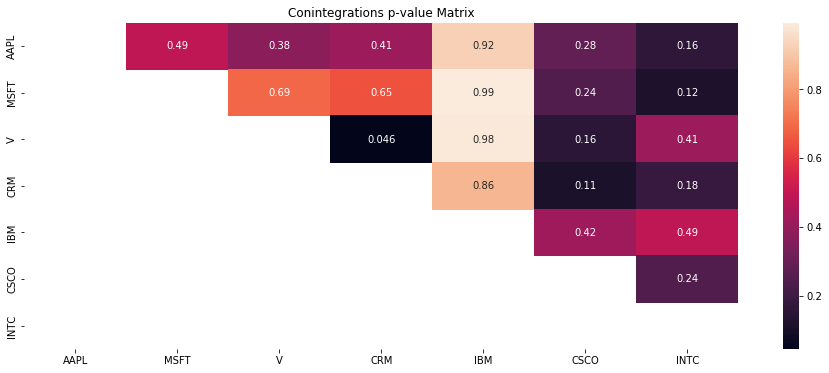

Warning pair: MSFT/INTC not best suitable for this strategy.
Returns might be negative

Warning pair: AAPL/CSCO not best suitable for this strategy.
Returns might be negative

Selected Pairs: ['V/CRM', 'MSFT/INTC', 'AAPL/CSCO']


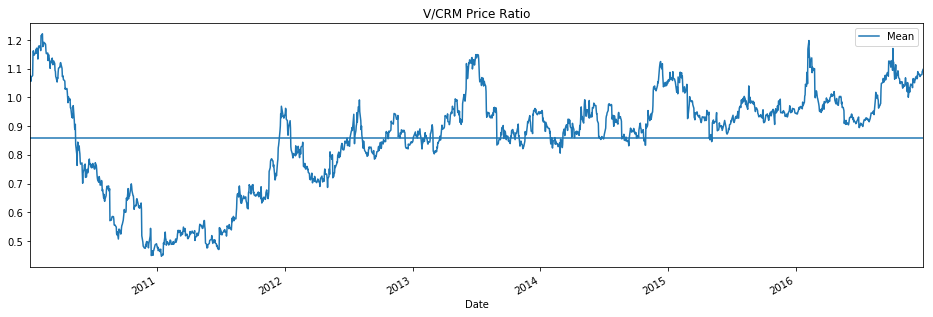

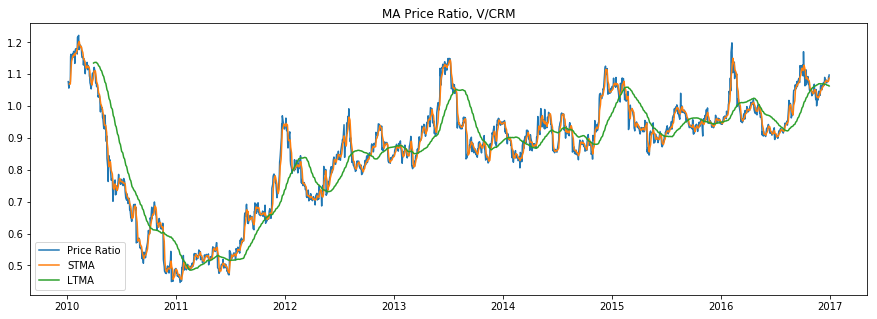

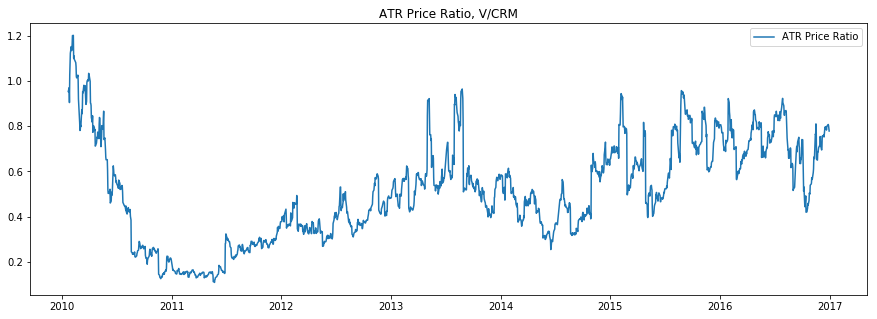

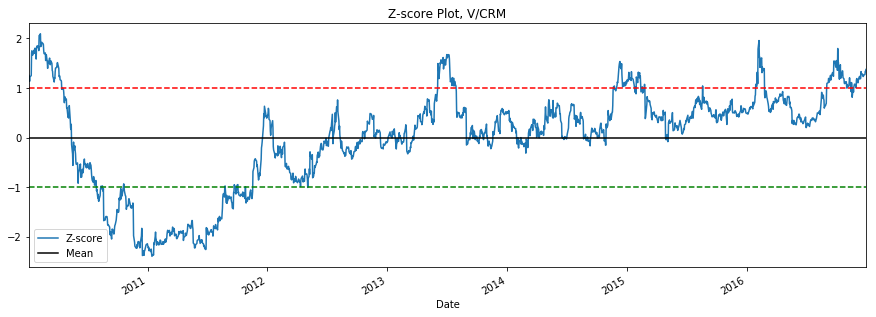

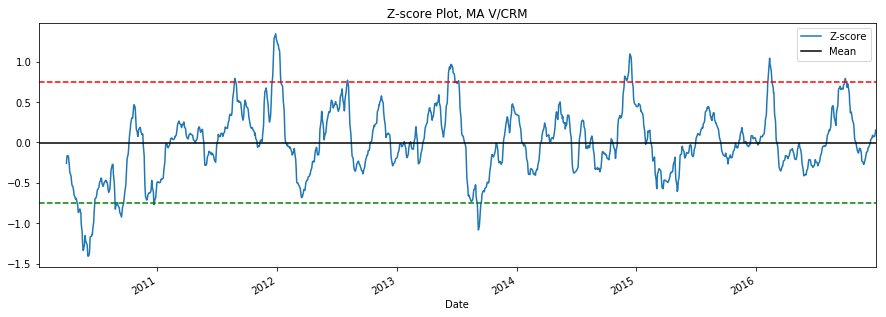

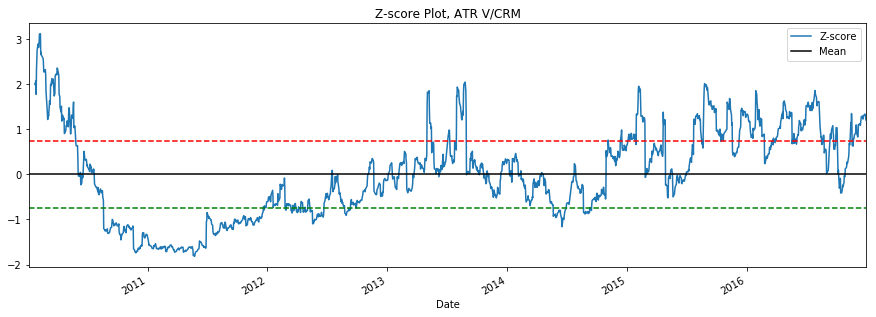

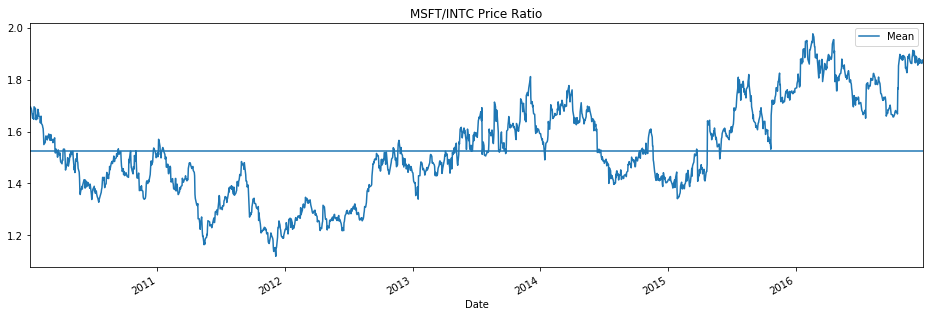

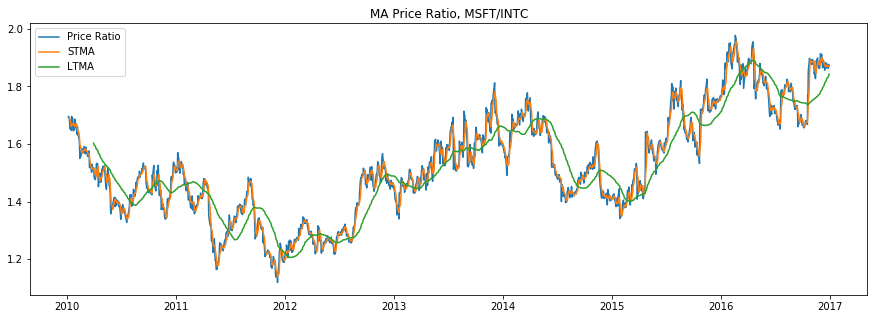

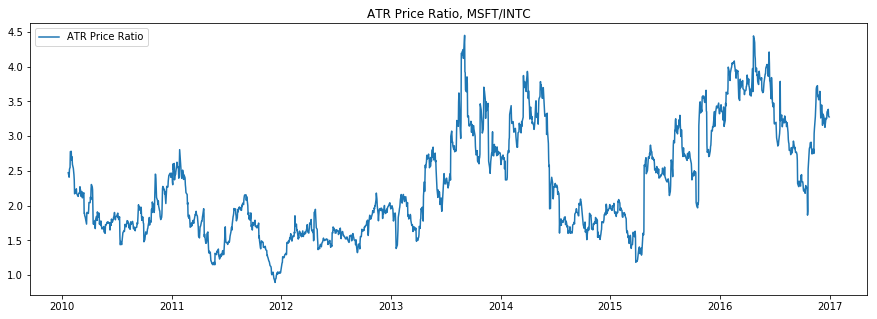

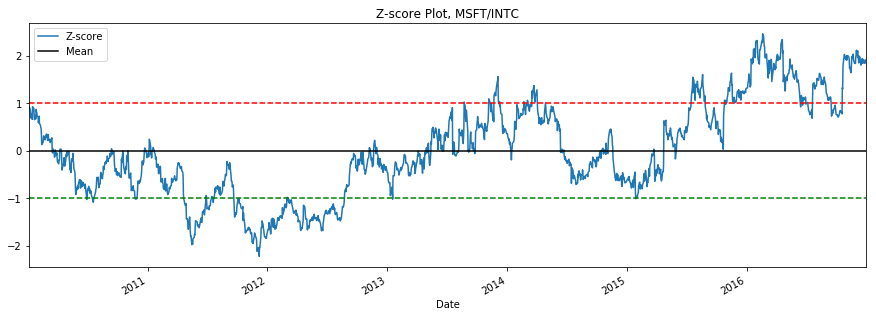

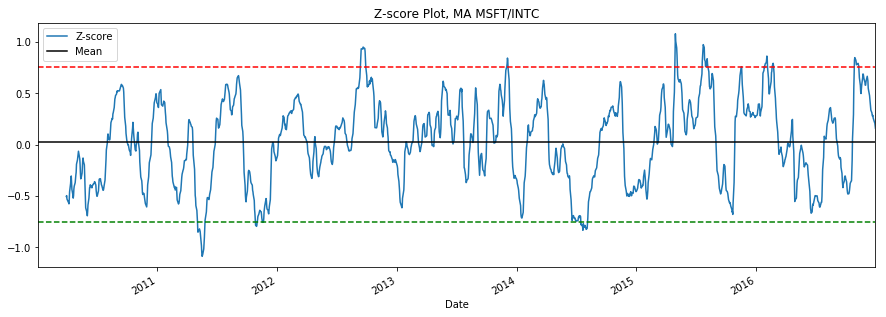

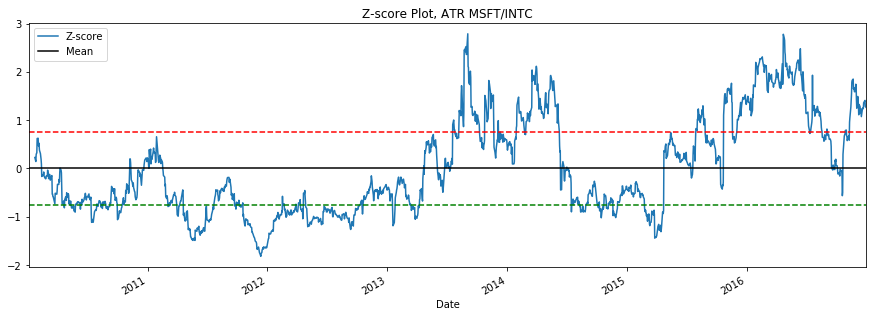

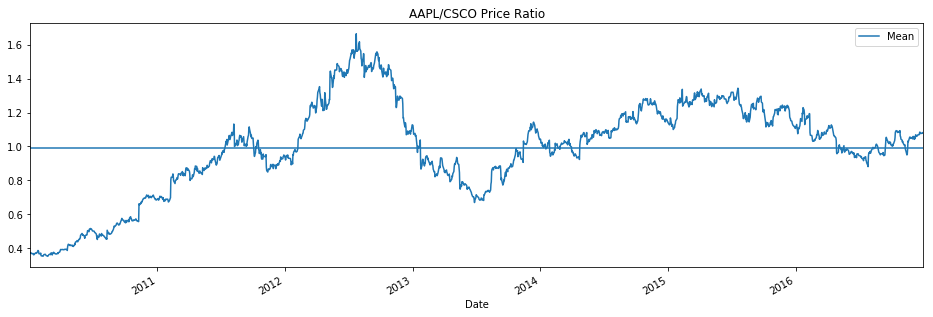

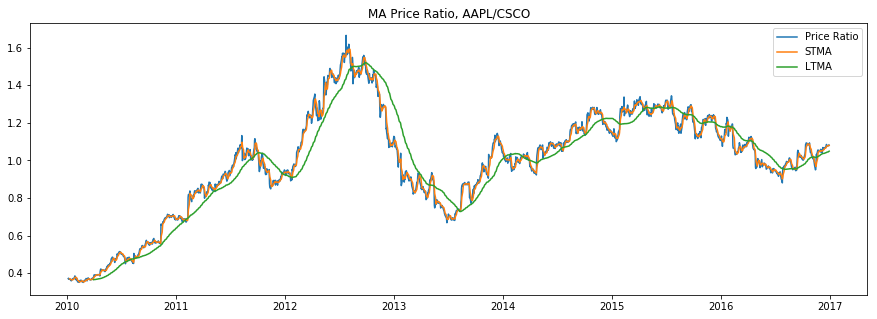

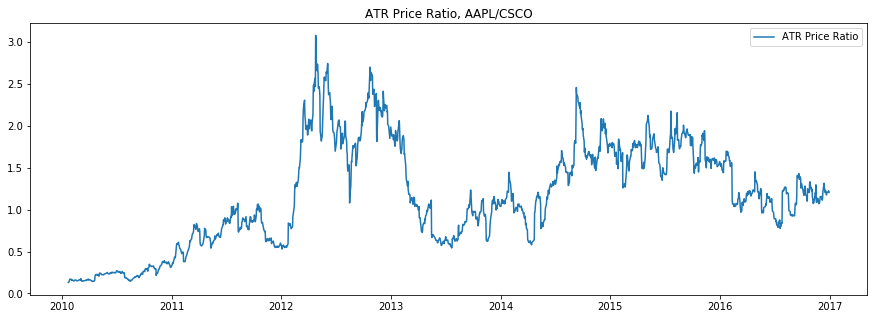

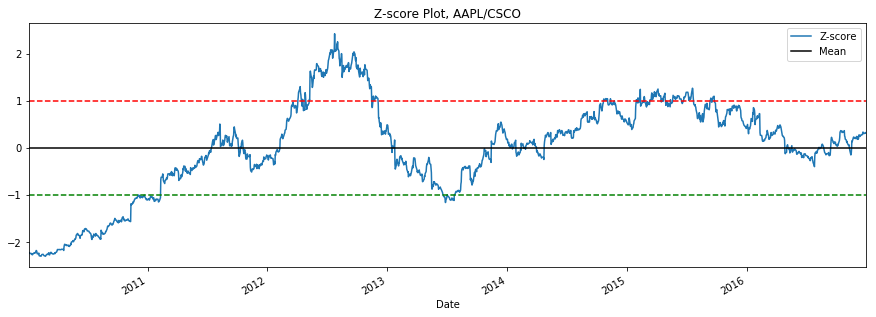

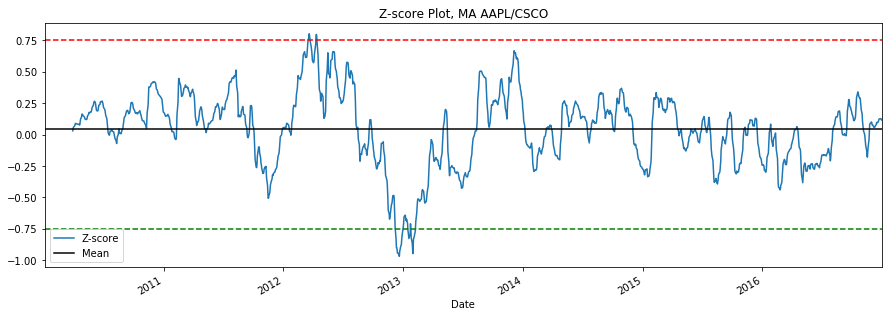

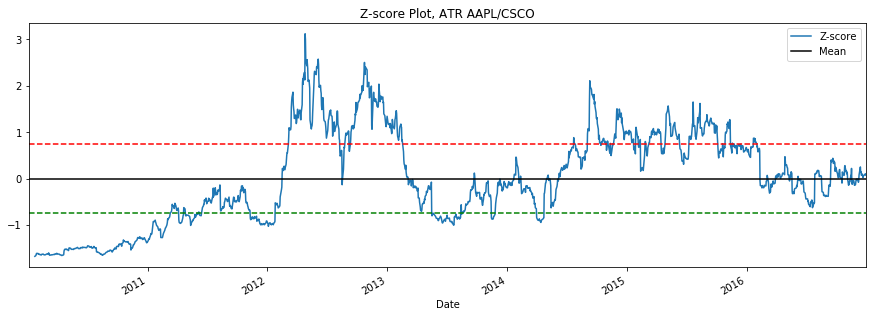

Strategy Iteration: RAW_RATIO



Open Trade V | 2010-01-04 | Sell
Open Price: $20.14
Quantity: 4096
Transaction Cost: $824.92
Total Price: $83316.94

Closing Trade V | 2010-05-20 | Buy
Close Price: $16.69
Quantity: 4096 
Transaction Cost: $683.58
Total Transaction Cost: $1508.5
Total Price: $69041.31
Log Returns: 0.21
Raw Profits: $12625.79
Open Trade V | 2010-07-23 | Buy
Open Price: $17.32
Quantity: 5483
Transaction Cost: $949.86
Total Price: $95935.84

Closing Trade V | 2011-12-16 | Sell
Close Price: $22.59
Quantity: 5483 
Transaction Cost: $1238.7
Total Transaction Cost: $2188.56
Total Price: $125109.03
Log Returns: 0.25
Raw Profits: $26695.78
Open Trade V | 2012-04-11 | Buy
Open Price: $27.27
Quantity: 4452
Transaction Cost: $1213.92
Total Price: $122606.15

Closing Trade V | 2012-06-22 | Sell
Close Price: $29.08
Quantity: 4452 
Transaction Cost: $1294.65
Total Transaction Cost: $2508.57
Total Price: $130759.88
Log Returns: 0.04
Raw Profits: $5564.43
Open Trade V | 2013-06-03 | Sell
Open Price: $42.27
Quantity: 3

Total Price: $125721.74

Closing Trade MSFT | 2014-01-13 | Buy
Close Price: $29.8
Quantity: 3856 
Transaction Cost: $1149.09
Total Transaction Cost: $2393.86
Total Price: $116058.15
Log Returns: 0.1
Raw Profits: $7174.06
Open Trade MSFT | 2014-01-31 | Sell
Open Price: $32.24
Quantity: 4081
Transaction Cost: $1315.57
Total Price: $132872.93

Closing Trade MSFT | 2014-06-13 | Buy
Close Price: $35.64
Quantity: 4081 
Transaction Cost: $1454.37
Total Transaction Cost: $2769.94
Total Price: $146891.31
Log Returns: -0.08
Raw Profits: $-16649.52
Open Trade MSFT | 2015-01-28 | Buy
Open Price: $36.05
Quantity: 3191
Transaction Cost: $1150.4
Total Price: $116190.19

Closing Trade MSFT | 2015-03-18 | Sell
Close Price: $37.46
Quantity: 3191 
Transaction Cost: $1195.43
Total Transaction Cost: $2345.83
Total Price: $120738.65
Log Returns: 0.02
Raw Profits: $2157.59
Open Trade MSFT | 2015-07-16 | Sell
Open Price: $41.4
Quantity: 2830
Transaction Cost: $1171.53
Total Price: $118324.66

Closing Trade MS

Transaction Cost: $1892.88
Total Transaction Cost: $3439.52
Total Price: $191180.48
Log Returns: 0.18
Raw Profits: $31183.66
Open Trade AAPL | 2014-10-22 | Sell
Open Price: $23.08
Quantity: 8040
Transaction Cost: $1855.34
Total Price: $187389.71

Closing Trade AAPL | 2016-05-02 | Buy
Close Price: $21.55
Quantity: 8040 
Transaction Cost: $1732.44
Total Transaction Cost: $3587.78
Total Price: $174976.11
Log Returns: 0.09
Raw Profits: $8702.92
Open Trade CSCO | 2010-01-04 | Sell
Open Price: $17.53
Quantity: 4705
Transaction Cost: $824.93
Total Price: $83318.2

Closing Trade CSCO | 2011-07-08 | Buy
Close Price: $11.26
Quantity: 4705 
Transaction Cost: $529.74
Total Transaction Cost: $1354.68
Total Price: $53504.23
Log Returns: 0.46
Raw Profits: $28164.11
Open Trade CSCO | 2012-03-19 | Buy
Open Price: $14.51
Quantity: 7606
Transaction Cost: $1103.78
Total Price: $111481.32

Closing Trade CSCO | 2013-01-14 | Sell
Close Price: $15.46
Quantity: 7606 
Transaction Cost: $1176.24
Total Transactio

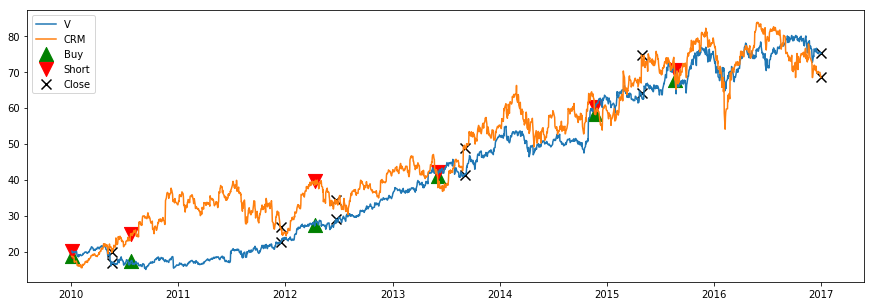

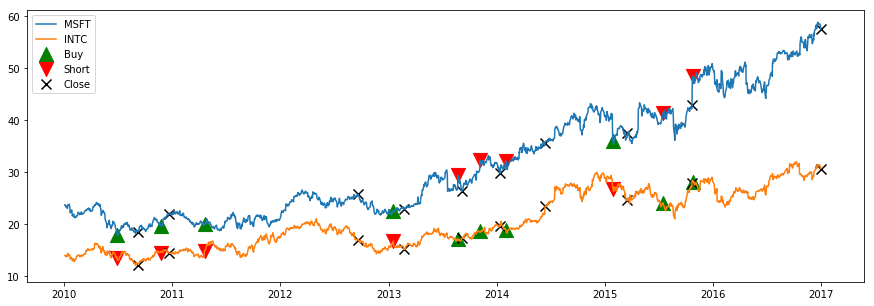

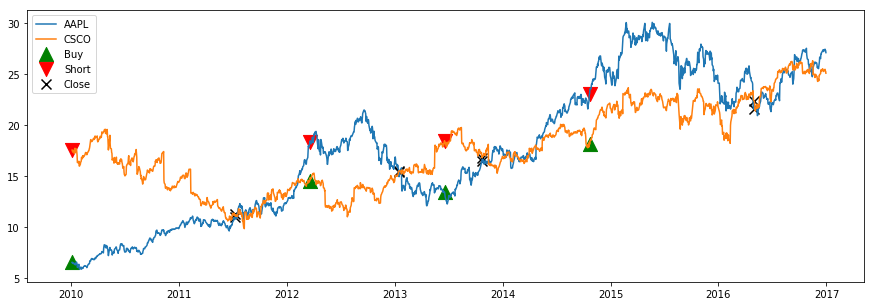

Total number of trades made: 40
Total number of winning trades: 29
Total number of losing trades: 11
Win Rate: 72.5%
Mean log returns: 9.37%


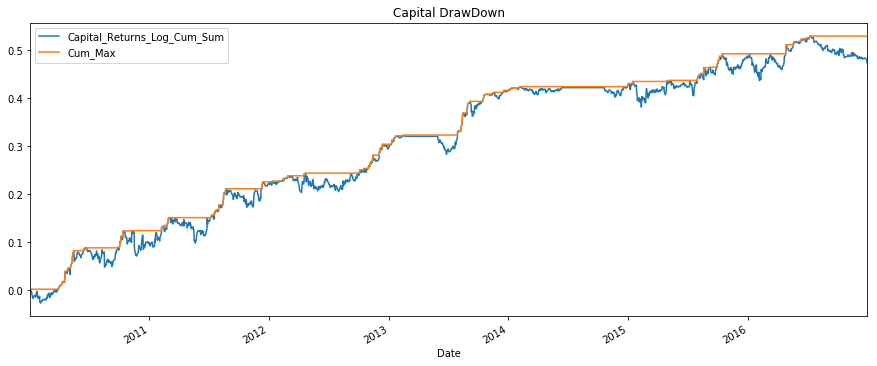

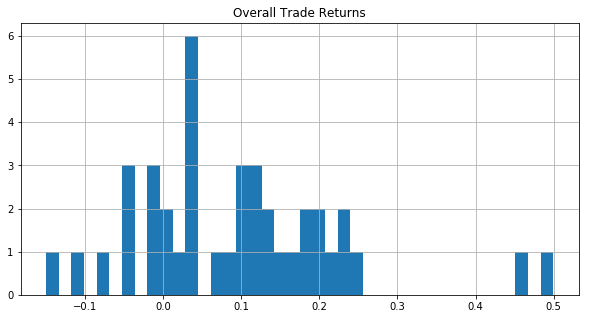


Strategy Performance
Strategy Returns: 59.56%
Strategy Annual Gross Returns: 7.02%
Strategy Standard Deviation: 7.07
Alpha: 7.02
Beta: 0.0
Sharpe Ratio: 0.99

Market Performance
Market Returns: 124.17%
Market Annual Gross Returns: 12.24%
Market Standard Deviation: 23.46

Calmar Ratio: 10.699299992487584
Sortino Ratio: 11.16
Annual Information Ratio: -0.2


C:\Users\Weilin\Anaconda3\lib\site-packages\ipykernel_launcher.py:404: RuntimeWarning: divide by zero encountered in double_scalars


Treynor Ratio: inf


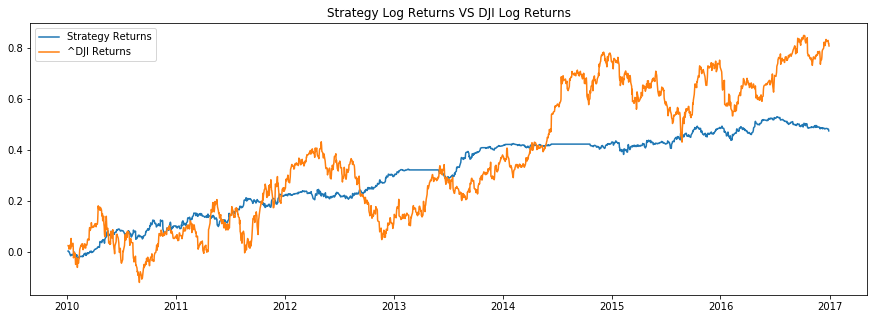

Resetting BackTester

Strategy Iteration: MA_RATIO



Open Trade V | 2010-04-27 | Buy
Open Price: $21.27
Quantity: 3878
Transaction Cost: $824.88
Total Price: $83312.43

Closing Trade V | 2010-10-06 | Sell
Close Price: $17.04
Quantity: 3878 
Transaction Cost: $660.82
Total Transaction Cost: $1485.7
Total Price: $66743.23
Log Returns: -0.24
Raw Profits: $-17890.84
Open Trade V | 2010-11-29 | Buy
Open Price: $17.07
Quantity: 3795
Transaction Cost: $647.63
Total Price: $65410.41

Closing Trade V | 2011-01-26 | Sell
Close Price: $16.33
Quantity: 3795 
Transaction Cost: $619.78
Total Transaction Cost: $1267.41
Total Price: $62597.9
Log Returns: -0.06
Raw Profits: $-4052.07
Open Trade V | 2011-08-24 | Sell
Open Price: $19.98
Quantity: 3040
Transaction Cost: $607.43
Total Price: $61350.73

Closing Trade V | 2011-10-25 | Buy
Close Price: $20.98
Quantity: 3040 
Transaction Cost: $637.67
Total Transaction Cost: $1245.1
Total Price: $64404.77
Log Returns: -0.03
Raw Profits: $-4268.91
Open Trade V | 2011-12-16 | Sell
Open Price: $22.59
Quantity: 250

Close Price: $57.79
Quantity: 1314 
Transaction Cost: $759.36
Total Transaction Cost: $1539.09
Total Price: $76695.42
Log Returns: -0.05
Raw Profits: $-3575.79
Open Trade CRM | 2016-02-05 | Buy
Open Price: $58.51
Quantity: 1272
Transaction Cost: $744.25
Total Price: $75168.97

Closing Trade CRM | 2016-03-02 | Sell
Close Price: $70.43
Quantity: 1272 
Transaction Cost: $895.87
Total Transaction Cost: $1640.12
Total Price: $90482.83
Log Returns: 0.17
Raw Profits: $13522.13
Open Trade CRM | 2016-09-23 | Buy
Open Price: $70.39
Quantity: 1247
Transaction Cost: $877.76
Total Price: $88654.09

Closing Trade CRM | 2016-10-27 | Sell
Close Price: $74.74
Quantity: 1247 
Transaction Cost: $932.01
Total Transaction Cost: $1809.77
Total Price: $94132.79
Log Returns: 0.04
Raw Profits: $3614.68
Open Trade MSFT | 2011-05-04 | Buy
Open Price: $20.53
Quantity: 4018
Transaction Cost: $825.08
Total Price: $83333.0

Closing Trade MSFT | 2011-06-22 | Sell
Close Price: $19.55
Quantity: 4018 
Transaction Cost: 

Open Trade INTC | 2014-06-19 | Sell
Open Price: $23.63
Quantity: 3610
Transaction Cost: $852.97
Total Price: $86150.19

Closing Trade INTC | 2014-09-09 | Buy
Close Price: $27.6
Quantity: 3610 
Transaction Cost: $996.19
Total Transaction Cost: $1849.16
Total Price: $100615.07
Log Returns: -0.14
Raw Profits: $-16170.83
Open Trade INTC | 2015-04-28 | Buy
Open Price: $26.46
Quantity: 2618
Transaction Cost: $692.75
Total Price: $69967.29

Closing Trade INTC | 2015-06-02 | Sell
Close Price: $26.85
Quantity: 2618 
Transaction Cost: $703.04
Total Transaction Cost: $1395.78
Total Price: $71006.81
Log Returns: -0.01
Raw Profits: $-366.56
Open Trade INTC | 2015-07-21 | Buy
Open Price: $23.18
Quantity: 2972
Transaction Cost: $688.95
Total Price: $69584.23

Closing Trade INTC | 2015-08-31 | Sell
Close Price: $23.23
Quantity: 2972 
Transaction Cost: $690.32
Total Transaction Cost: $1379.27
Total Price: $69722.53
Log Returns: -0.02
Raw Profits: $-1242.34
Open Trade INTC | 2015-11-16 | Buy
Open Price:

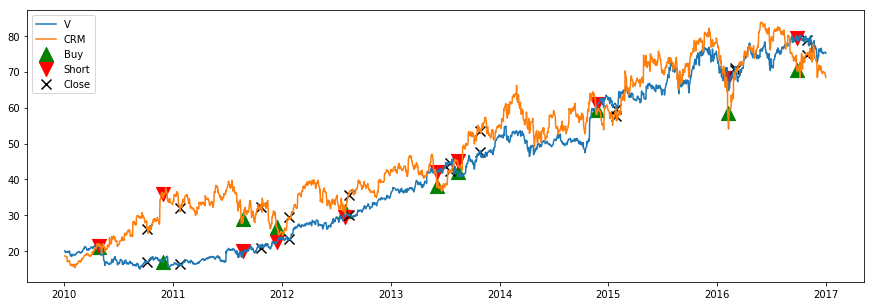

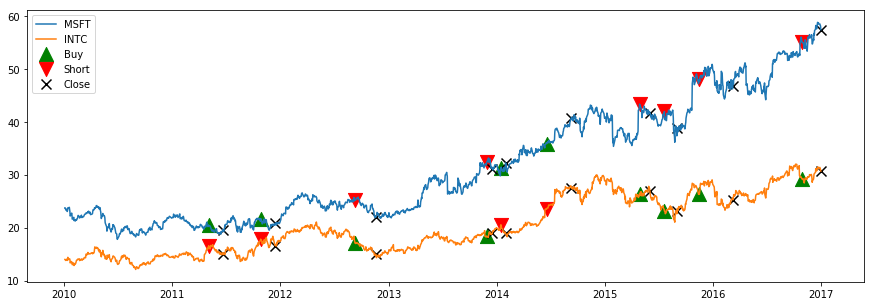

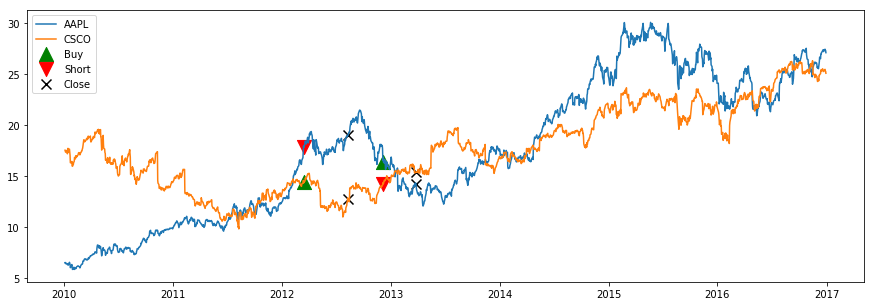

Total number of trades made: 44
Total number of winning trades: 21
Total number of losing trades: 23
Win Rate: 47.73%
Mean log returns: 0.16%


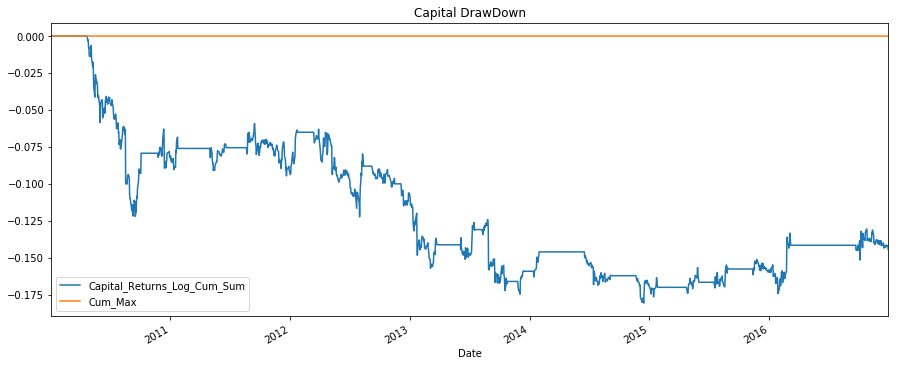

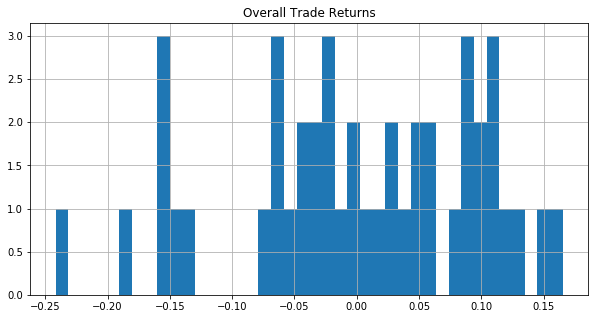


Strategy Performance
Strategy Returns: -13.45%
Strategy Annual Gross Returns: -2.05%
Strategy Standard Deviation: 4.67
Alpha: -2.05
Beta: 0.0
Sharpe Ratio: -0.44

Market Performance
Market Returns: 124.17%
Market Annual Gross Returns: 12.24%
Market Standard Deviation: 23.46

Calmar Ratio: -0.7441122342169029
Sortino Ratio: -2.51
Annual Information Ratio: -0.58
Treynor Ratio: -inf


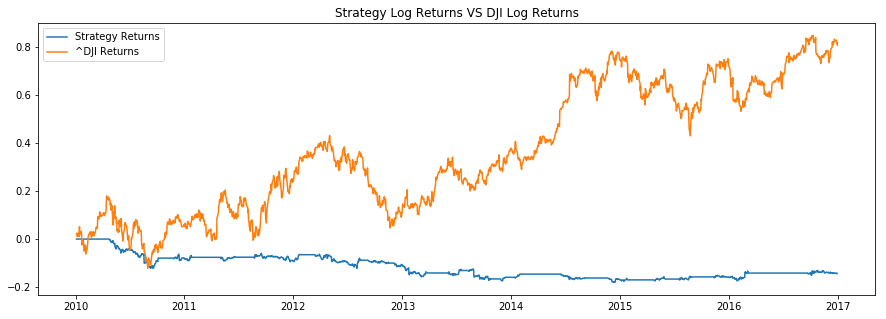

Resetting BackTester

Strategy Iteration: ATR_RATIO



Open Trade MSFT | 2010-03-23 | Buy
Open Price: $23.04
Quantity: 3581
Transaction Cost: $824.92
Total Price: $83316.68

Closing Trade MSFT | 2010-04-08 | Sell
Close Price: $23.07
Quantity: 3581 
Transaction Cost: $826.02
Total Transaction Cost: $1650.94
Total Price: $83428.2
Log Returns: -0.02
Raw Profits: $-1540.52
Open Trade MSFT | 2010-04-15 | Buy
Open Price: $23.8
Quantity: 3402
Transaction Cost: $809.65
Total Price: $81774.51

Closing Trade MSFT | 2010-11-11 | Sell
Close Price: $20.77
Quantity: 3402 
Transaction Cost: $706.66
Total Transaction Cost: $1516.31
Total Price: $71372.85
Log Returns: -0.16
Raw Profits: $-11814.99
Open Trade MSFT | 2011-03-04 | Buy
Open Price: $20.45
Quantity: 3387
Transaction Cost: $692.57
Total Price: $69949.58

Closing Trade MSFT | 2013-04-22 | Sell
Close Price: $25.7
Quantity: 3387 
Transaction Cost: $870.6
Total Transaction Cost: $1563.17
Total Price: $87930.96
Log Returns: 0.21
Raw Profits: $16240.17
Open Trade MSFT | 2013-05-21 | Sell
Open Price: $

Transaction Cost: $1134.31
Total Price: $114564.82

Closing Trade INTC | 2015-09-30 | Sell
Close Price: $24.53
Quantity: 4861 
Transaction Cost: $1192.39
Total Transaction Cost: $2326.69
Total Price: $120431.29
Log Returns: 0.03
Raw Profits: $3481.69
Open Trade INTC | 2015-10-23 | Buy
Open Price: $28.4
Quantity: 4114
Transaction Cost: $1168.53
Total Price: $118021.22

Closing Trade INTC | 2016-09-16 | Sell
Close Price: $31.65
Quantity: 4114 
Transaction Cost: $1302.2
Total Transaction Cost: $2470.73
Total Price: $131522.37
Log Returns: 0.09
Raw Profits: $10896.74
Open Trade INTC | 2016-10-27 | Buy
Open Price: $29.25
Quantity: 4363
Transaction Cost: $1276.17
Total Price: $128892.87

Closing Trade INTC | 2016-12-30 | Sell
Close Price: $30.71
Quantity: 4363 
Transaction Cost: $1339.76
Total Transaction Cost: $2615.93
Total Price: $135315.71
Log Returns: 0.03
Raw Profits: $3743.32
Open Trade V | 2010-01-22 | Sell
Open Price: $18.9
Quantity: 4364
Transaction Cost: $824.95
Total Price: $8331

Total Transaction Cost: $1904.13
Total Price: $90618.2
Log Returns: 0.14
Raw Profits: $9066.52
Open Trade CRM | 2012-08-20 | Sell
Open Price: $36.89
Quantity: 2972
Transaction Cost: $1096.45
Total Price: $110740.96

Closing Trade CRM | 2012-11-01 | Buy
Close Price: $36.56
Quantity: 2972 
Transaction Cost: $1086.41
Total Transaction Cost: $2182.86
Total Price: $109727.88
Log Returns: 0.03
Raw Profits: $-1179.81
Open Trade CRM | 2013-05-02 | Buy
Open Price: $41.87
Quantity: 2590
Transaction Cost: $1084.43
Total Price: $109527.73

Closing Trade CRM | 2013-05-29 | Sell
Close Price: $41.93
Quantity: 2590 
Transaction Cost: $1085.99
Total Transaction Cost: $2170.42
Total Price: $109684.69
Log Returns: -0.02
Raw Profits: $-2015.02
Open Trade CRM | 2013-07-05 | Buy
Open Price: $38.94
Quantity: 2733
Transaction Cost: $1064.23
Total Price: $107487.25

Closing Trade CRM | 2013-08-30 | Sell
Close Price: $49.13
Quantity: 2733 
Transaction Cost: $1342.72
Total Transaction Cost: $2406.95
Total Price:

Open Trade CSCO | 2012-08-24 | Buy
Open Price: $13.95
Quantity: 6688
Transaction Cost: $933.11
Total Price: $94244.21

Closing Trade CSCO | 2013-02-28 | Sell
Close Price: $15.38
Quantity: 6688 
Transaction Cost: $1028.85
Total Transaction Cost: $1961.96
Total Price: $103914.13
Log Returns: 0.08
Raw Profits: $7612.22
Open Trade CSCO | 2013-04-15 | Sell
Open Price: $15.65
Quantity: 6444
Transaction Cost: $1008.43
Total Price: $101851.71

Closing Trade CSCO | 2013-05-15 | Buy
Close Price: $15.77
Quantity: 6444 
Transaction Cost: $1016.1
Total Transaction Cost: $2024.53
Total Price: $102625.86
Log Returns: 0.01
Raw Profits: $-2791.02
Open Trade CSCO | 2013-05-16 | Sell
Open Price: $17.76
Quantity: 5522
Transaction Cost: $980.74
Total Price: $99054.25

Closing Trade CSCO | 2013-09-24 | Buy
Close Price: $18.07
Quantity: 5522 
Transaction Cost: $997.97
Total Transaction Cost: $1978.7
Total Price: $100794.84
Log Returns: 0.0
Raw Profits: $-3702.06
Open Trade CSCO | 2013-11-14 | Sell
Open Price

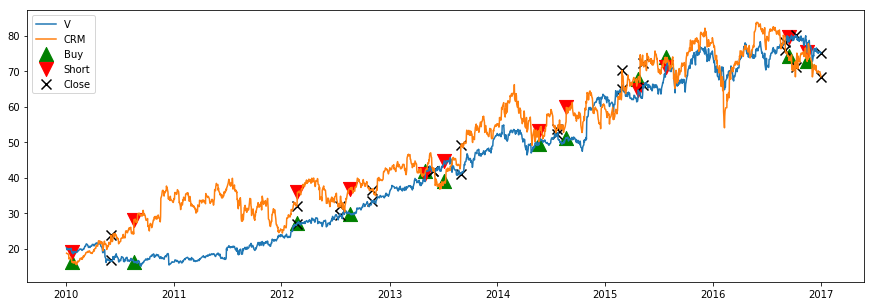

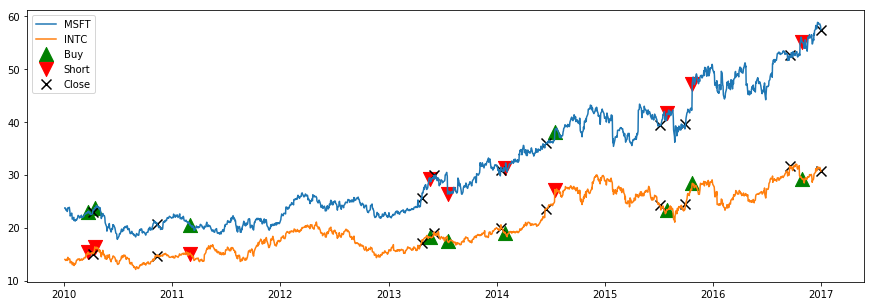

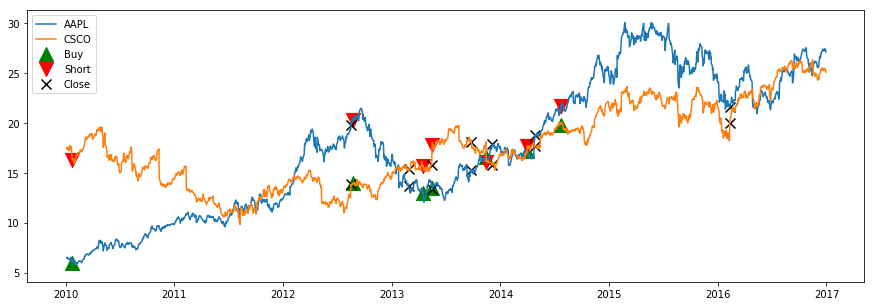

Total number of trades made: 58
Total number of winning trades: 32
Total number of losing trades: 26
Win Rate: 55.17%
Mean log returns: 7.11%


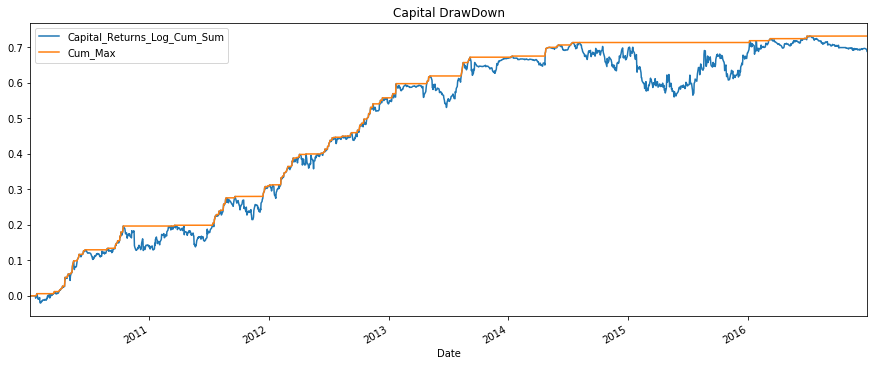

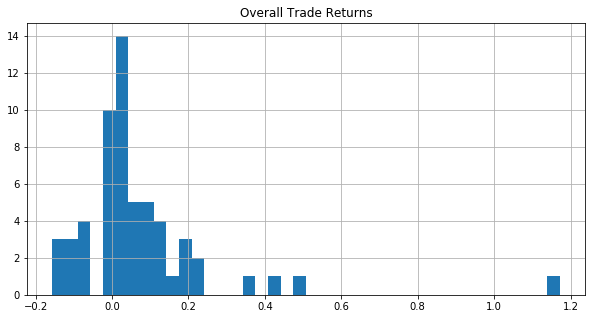


Strategy Performance
Strategy Returns: 99.18%
Strategy Annual Gross Returns: 10.36%
Strategy Standard Deviation: 10.35
Alpha: 10.24
Beta: 0.01
Sharpe Ratio: 1.0

Market Performance
Market Returns: 124.17%
Market Annual Gross Returns: 12.24%
Market Standard Deviation: 23.46

Calmar Ratio: 6.463772988981624
Sortino Ratio: 13.08
Annual Information Ratio: -0.07
Treynor Ratio: 99.18


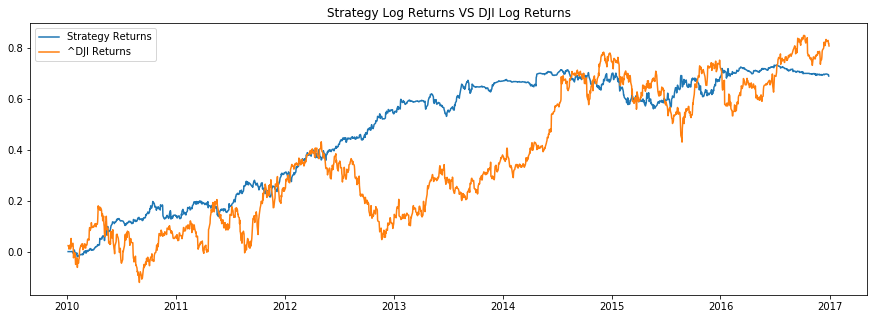

Resetting BackTester



In [204]:
A = Pair_Strategy(stocks, "2010-01-01", "2016-12-31","1d", 500000, 0.01, "^DJI" ,verbose=True, number_pairs=number_of_pairs, types=strategy_types)
A.run_strategy()

In [ ]:
A.price_signals

In [127]:
A.data

,Close_Price_AAPL,High_AAPL,Low_AAPL,Return_AAPL,Close_Price_MSFT,High_MSFT,Low_MSFT,Return_MSFT,Close_Price_V,High_V,...,Low_INTC,Return_INTC,Close_Price_^DJI,Return_^DJI,ATR_CRM,ATR_CSCO,ATR_MSFT,ATR_V,ATR_IBM,ATR_INTC
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,24.111498,24.116076,23.344782,0.000854,49.269154,49.269154,48.001462,-0.012332,72.352295,73.002223,...,27.423547,-0.013442,27.857933,-0.013442,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-05,23.507280,24.225933,23.438620,-0.025379,49.493935,49.799619,49.035409,0.004552,72.897087,73.126479,...,27.480915,-0.004718,27.726795,-0.004718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-06,23.047247,23.429462,22.857286,-0.019764,48.594852,48.909530,48.226233,-0.018333,71.941299,72.495652,...,26.882617,-0.022419,27.112104,-0.022419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-07,22.074554,22.916798,22.069978,-0.043121,46.904591,48.091369,46.814685,-0.035402,70.526764,71.769269,...,26.095802,-0.038206,26.095802,-0.038206,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-08,22.191275,22.683346,22.145501,0.005274,47.048447,47.902562,46.886613,0.003062,69.656975,71.214895,...,25.759777,-0.010418,25.825344,-0.010418,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-11,22.550600,22.671901,22.278244,0.016062,47.021469,47.515958,46.266248,-0.000574,70.650970,70.803898,...,25.964672,0.017304,26.276117,0.017304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-12,22.877890,23.044966,22.621554,0.014409,47.453030,47.740732,46.805700,0.009136,71.453850,71.683234,...,26.448235,0.019154,26.784267,0.019154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-13,22.289690,23.159398,22.269093,-0.026047,46.428074,48.612819,46.122389,-0.021836,69.867264,72.055993,...,26.087610,-0.023844,26.153177,-0.023844,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-14,22.777184,22.996901,21.912054,0.021635,47.749718,48.028428,46.365146,0.028069,70.536316,71.224469,...,26.063021,0.025678,26.833439,0.025678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
